# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Hough-Transforms-for-Line-and-Circle-Detection" data-toc-modified-id="Hough-Transforms-for-Line-and-Circle-Detection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Hough Transforms for Line and Circle Detection</a></div><div class="lev3 toc-item"><a href="#Straight-Line-Detection" data-toc-modified-id="Straight-Line-Detection-101"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Straight Line Detection</a></div><div class="lev3 toc-item"><a href="#Circle-Detection" data-toc-modified-id="Circle-Detection-102"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Circle Detection</a></div><div class="lev2 toc-item"><a href="#Visualizing-the-Effect-of-Parameter-Values" data-toc-modified-id="Visualizing-the-Effect-of-Parameter-Values-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Visualizing the Effect of Parameter Values</a></div><div class="lev3 toc-item"><a href="#Effect-of--dp-parameter" data-toc-modified-id="Effect-of--dp-parameter-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Effect of  <code>dp</code> parameter</a></div><div class="lev1 toc-item"><a href="#Apple-Detection" data-toc-modified-id="Apple-Detection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Apple Detection</a></div><div class="lev2 toc-item"><a href="#Results-with-Manual-Parameter-Tuning-and-Proposal-Rejection" data-toc-modified-id="Results-with-Manual-Parameter-Tuning-and-Proposal-Rejection-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Results with Manual Parameter Tuning and Proposal Rejection</a></div><div class="lev1 toc-item"><a href="#Addendum:-Deep-Learning-with-Synthetic-Data" data-toc-modified-id="Addendum:-Deep-Learning-with-Synthetic-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Addendum: Deep Learning with Synthetic Data</a></div>

The other day on [freelancer.com](www.freelancer.com) I came across a cool job post where the client needed an algorithm developed to detect the centers of all the apples in images taken from their conveyer belt system. Since it looked like such a fun project I immediately downloaded the set of 9 example images they had attached and starting playing with them. This is what they looked like:

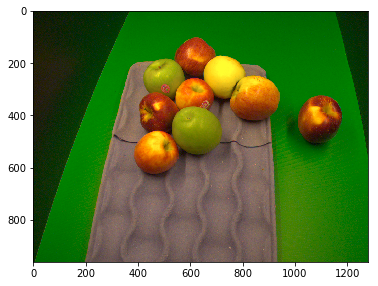

In [5]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
data_path = "./data/R1/"

image = cv2.imread(data_path + "Img03.png")
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

Naturally by the time I decided to stop playing and submit a proposal, the project had been closed for bidding... But I *did* learn a bit about circle detection in OpenCV in the process. Below is a very simple overview of the algorithm and some visualizations of the effect of different parameters. 

# Hough Transforms for Line and Circle Detection

### Straight Line Detection
A great, simple intro to using Hough Transforms for straight line and circle detection can be found in [section 4.3](http://homepages.inf.ed.ac.uk/rbf/BOOKS/BANDB/LIB/bandb4_3.pdf) of the freely available [*Computer Vision* by Ballard & Brown](http://homepages.inf.ed.ac.uk/rbf/BOOKS/BANDB/bandb.htm). The algorithm can very loosely be thought of in the following steps:

**Straight Line Detection Algorithm**
- Straight lines can be parameterized by two parameters (like slope and intercept). Create an empty matrix called an **Accumulator Matrix** where each element represents a different possible line (e.g. rows represent possible values of slope and columns represent possible values of intercept).
- Run an edge detection algorithm on the input image to highlight all pixels likely to be on an *edge*
- For every edge pixel identified:
    - For every element in the Accumulator Matrix (i.e. every possible straight line):
        - If the edge pixel is very close to lying on that line, add some "weight" to that matrix element
- The elements of the Accumulator Matrix with large values now represent lines which intersect a large number of the edge points from the image.

### Circle Detection
A circle can be parameterized by three parameters (the radius, center x and center y coordinates) so this method can also perform circle detection simply by using a three-dimensional Accumulator Matrix. However this adds a significant amount of computation. Let us also add in information about the gradient of the gray scale image at every point. Now when considering a single edge pixel, every potential circle (element in the Accumulator Matrix) only gets weighted if the edge pixel lies on that circle border AND the gradient of the image at the pixel point is in the same direction as the surface normal at that spot on the circle border. That is, the circle border has to contain the pixel and the circle's gradient has to be aligned with the image's gradient at that point. In the popular `opencv` package this method is implemented in [`HoughCircles()`](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=houghcircles#houghcircles); it can be a little tricky to get this function working the way you want, hopefully the parameter descriptions below will make the tuning somewhat more intuitive.

`HoughCircles()` Parameters:
- **`dp`** controls the resolution of the parameters in the Accumulator Matrix, i.e. the coarseness of the grid. If `dp` is *high* then the matrix has *low* resolution, meaning only a coarse grid of possible lines/circles is considered from the space of all possible ones. The effect is that an edge pixel can accumulate lines/circles that are not that great of a match to it simply because they are the closest matches on the coarse grid of options. Consequently we will identify more circles resulting from regions with less precisely shaped boundaries.
- **`param1`** is actually a parameter passed to the edge detection preprocessing step. If `param1` is low then more weak edges will be found and therefore more weak and/or false circle boundaries will be returned by `HoughCircles()`
- **`param2`** is the threshold value for the final selection of elements from the Accumulator Matrix. If `param2` is *low* then more lines/circles will be returned by `HoughCircles()`.

Note that a major part of the feasibility of these algorithms is that in actual implementation it is not necessary to loop through and check every element in the Accumulator Matrix; rather there are efficient ways to (parametrically) identify the subset of elements that should be accumulated for any given image edge pixel.

Clearly the initial edge detection step is a crucial part of optimizing this algorithm. The default in the OpenCV Hough Transform function is called [*Canny Edge Detection*](https://en.wikipedia.org/wiki/Canny_edge_detector#Process_of_Canny_edge_detection_algorithm). If you are having issues getting the Hough methods to behave, a good sanity check is inspecting the output of the Canny edge detection preprocessing step. Similarly, for ultimate optimization of these detection techniques I would recommend manually tuning the edge detection preprocessing step, and then passing your resulting edge images through to the Hough methods.

## Visualizing the Effect of Parameter Values

Let's take a look at the effect of varying `param1` and `param2` over a grid of possible values for two of the example images, and then repeat this visualization for low versus high values of `dp`.

In [6]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
data_path = "./data/R1/"

In [7]:
def scan_params(imname="Img01", dp=1.1, param1_bounds=(70, 130), param2_bounds=(15, 30), 
                minDist=80, minRadius=65, maxRadius=125, method=cv2.HOUGH_GRADIENT,):
    '''Applies circle detection and plots the found circles for a grid of possible HoughCircles parameter values.'''
    
    num_y, num_x = 4, 6  # Panel subplot dimensions

    param1s, params2 = np.meshgrid(np.linspace(param1_bounds[0], param1_bounds[1], num=num_x), 
                                   np.linspace(param2_bounds[0], param2_bounds[1], num=num_y))  # Param1 and param2 values on a grid

    # Create panel plotting object
    fig, axs = plt.subplots(nrows=num_y, ncols=num_x, figsize=(12, 7), sharex=True, sharey=True)

    # Read in image and convert to grayscale
    impath = data_path + imname + ".png"
    image = cv2.imread(impath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # For each possible pair of parameter values, apply circle detection and plot the results
    for index, ax in np.ndenumerate(axs):
        y, x = index
            
        param1, param2 = param1s[y, x], params2[y, x]
        
        # Set subplot labels for param1, param2 values (only on border subplots)
        if x==0:
            ax.set_ylabel("param2=%.0f" % (param2,))
        if y==num_y-1:
            ax.set_xlabel("param1=%.0f" % (param1,))
            
        # Set figure title with dp value
        fig.suptitle("Parameter dp=%.1f" % (dp,), fontsize=20, y=0.95)
            
        # Turn off ticks/ticklabels
        ax.set_xticks([])
        ax.set_yticks([])
            
        # Detect proposed circles
        circles_proposed = cv2.HoughCircles(image=gray, method=method, dp=dp, minDist=minDist, param1=param1, param2=param2, 
                                   minRadius=minRadius, maxRadius=maxRadius)

        # Eliminate any false circles found on the gray tray background, and plot valid circles
        output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # opencv defaults to BGR channel config, pyplot expects RGB
        if circles_proposed is not None:

            circles_proposed = np.round(circles_proposed[0, :]).astype("int")  # round center coordinates and radius to integer pixels

            # Draw valid circles with their centerpoints onto the original image
            for (x, y, r) in circles_proposed:
                circ_color, rsize = (255, 255, 255), 10  # set plotting parameters
                cv2.circle(output, (x, y), r, circ_color, 4)  # draw the circle
                cv2.rectangle(output, (x - rsize, y - rsize), (x + rsize, y + rsize), circ_color, -1)  # draw a small rectangle at the center
        ax.imshow(output)

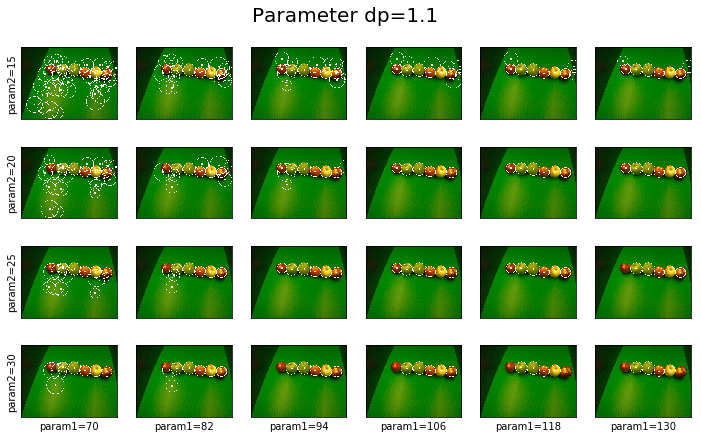

In [8]:
scan_params(imname="Img09")

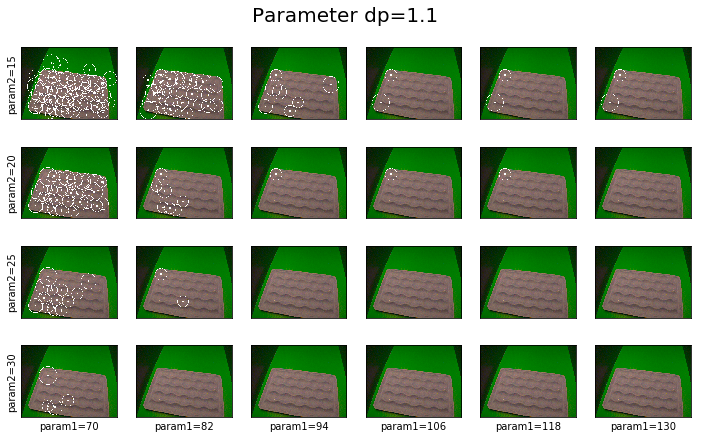

In [9]:
scan_params(imname="Img08")

### Effect of  `dp` parameter

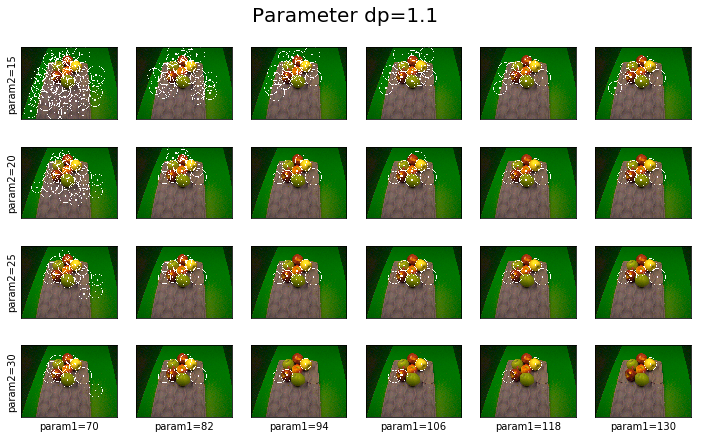

In [10]:
scan_params(imname="Img01", dp=1.1)

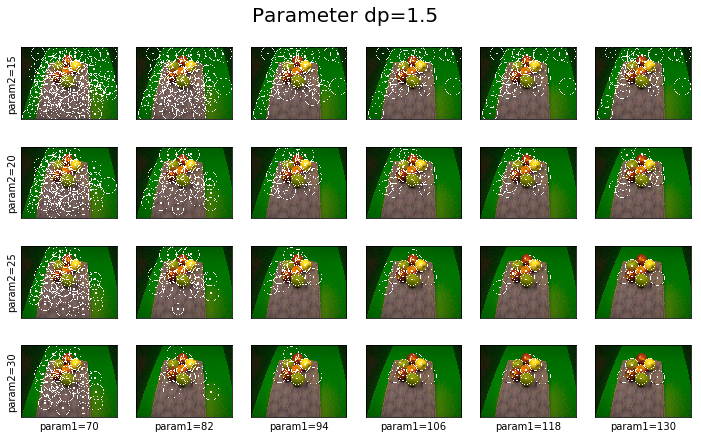

In [11]:
scan_params(imname="Img01", dp=1.5)

# Apple Detection

The results of the detection are obviously HIGHLY sensitive to all three parameters. The best approach here would be to label ground truths on the images (i.e. list the correct center coordinates for each true apple on each image), define an error metric that quantifies how well the algorithm performs (i.e. penalize finding erroneous circles, reward closely pinpointing real apples), and then search over the parameter space to minimize this error metric. Note that we would want a very large and representative set of images to do this with, otherwise we will overfit the parameter values to our sample and the algorithm might not generalize well to future images.

For this particular use case, beyond optimizing the parameters algorithmically we could also:
- Add additional preprocessing to enhance certain helpful image features (for instance, focus in on particular colors). This [stack exchange answer](https://stackoverflow.com/a/25751990) had the idea of making round objects "rounder", while [this one](https://answers.opencv.org/question/175956/hough-circle-detection-if-circle-extends-outside-of-image/) discussed how to handle round objects extending beyond the image border.
- Add additional post-processing to reject proposed centerpoints based on certain conditions. For instance, if the color of the image near the proposed centerpoint matches the range of gray tones of the tray, it is likely a false detection.
- Since apples are not perfect circles, and we may want to also detect apples which are "cut off" by the frame of the image, then we could investigate using "blob analysis" (see this [stack exchange answer](https://stackoverflow.com/a/24054021) rather than circle detection.

## Results with Manual Parameter Tuning and Proposal Rejection

In lieu of labeling the images, I did a little manual tuning based on the insight that the apple borders are all quite high contrast edges, meaning I could pass a relatively high value for `param1` to the Canny edge detection and still retain those particular borders. This allowed me to use a correspondingly more relaxed value for `param2` (the accumulator threshold). I also went ahead and added the simple post-processing step of rejecting any proposed circles that were obviously centered on the gray tray (based on looking at the color of the center point pixel). The results of running this very naive method on the 9 example images are plotted below.

In [12]:
def iterate_panel(method=cv2.HOUGH_GRADIENT, dp=1.1, minDist=120, param1=90, param2=25, minRadius=70, maxRadius=125):
    '''Applies center point detection and plots the results for all of the images in the preliminary data set.'''
    
    # Create panel plotting object
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 4))
    axs = axs.ravel()
    fig.suptitle("Naive Apple Detection Results on Example Images", fontsize=20, y=0.95)
    
    # For each image, apply circle detection and plot the results
    for i, ax in enumerate(axs[:-1]):
        impath = data_path + "Img0" + str(i+1) + ".png"
        image = cv2.imread(impath)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Detect proposed circles
        circles_proposed = cv2.HoughCircles(image=gray, method=method, dp=dp, minDist=minDist, param1=param1, param2=param2, 
                                   minRadius=minRadius, maxRadius=maxRadius)
        
        # Create a mask representing pixels belong to the gray tray background
        gray_lower, gray_upper = np.array([70, 70, 70]), np.array([200, 200, 200])  # The range of colors for the gray tray
        masked = cv2.bitwise_and(gray, gray, mask=cv2.inRange(image, gray_lower, gray_upper))

        # Eliminate any false circles found on the gray tray background, and plot valid circles
        output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # opencv defaults to BGR channel config, pyplot expects RGB
        if circles_proposed is not None:
            
            circles_proposed = np.round(circles_proposed[0, :]).astype("int")  # round center coordinates and radius to integer pixels
            
            # Eliminate any false circles from the gray tray
            circles = []
            for (x, y, r) in circles_proposed:
                if masked[y, x] == 0:
                    circles.append((x, y, r))
            
            # Draw valid circles with their centerpoints onto the original image
            for (x, y, r) in circles:
                circ_color, rsize = (255, 255, 255), 10  # set plotting parameters
                cv2.circle(output, (x, y), r, circ_color, 4)  # draw the circle
                cv2.rectangle(output, (x - rsize, y - rsize), (x + rsize, y + rsize), circ_color, -1)  # draw a small rectangle at the center
                
        ax.imshow(output)
        
    # Turn off ticks/ticklabels
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

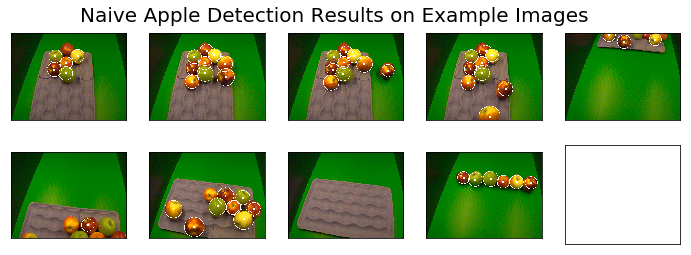

In [13]:
iterate_panel(method=cv2.HOUGH_GRADIENT, dp=1.1, minDist=80, param1=100, param2=23, 
              minRadius=65, maxRadius=125)

# Addendum: Deep Learning with Synthetic Data
One interesting thought I had is that this problem may be very well suited to synthetic data techniques for deep learning. Briefly, deep learning algorithms for computer vision have the drawback of requiring a LOT of labeled images to train them with. Normally you have to acquire the images, pay a human labeler to assign labels, and monitor to make sure the labeling is accurate. For this particular use case, I think it might be feasible to synthetically create training images (with known values labels) which would open the door to using deep learning techniques. For example, we can create training images by drawing the black/green background, picking a random location and orientation to draw the gray tray, picking a random number redish circles with randomly chosen sizes to draw  and likewise for greenish circles. 

This is a gross oversimplification, and the more elaborate the synthesizing algorithm is the more robust of a training set you can create with it. But even with a relatively simple algorithm this might allow us to do some first-round tuning of the weights for a pretrained imagenet model, and do the final tuning with a smaller set of real labeled images.